# Logistic Regression

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import preprocessing # LabelEncoder
from sklearn.preprocessing import MinMaxScaler # Escala los datos
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import scikitplot as skplt 
from string import ascii_uppercase 
# import seaborn as sns
import qgrid
import time
#from sklearn.externals import joblib # Para guardar el modelo
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy import stats #Para la moda


## LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression

In [ ]:
def loadCSV(pathSamples, pathMatrix):
    df_loaded = pd.read_table(pathMatrix, sep=',')
    data = pd.read_table(pathSamples, sep=',')
    clin_trial_values = df_loaded.values
    
    Y = data['Eligible']
    Y = Y.astype(int)
    X = clin_trial_values[:, :]
    return X,Y;

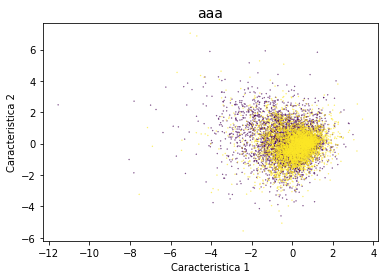

In [21]:
plt.figure()
plt.title('aaa', fontsize=14)
plt.xlabel('Caracteristica 1')
plt.ylabel('Caracteristica 2')
plt.scatter(X[:,0], X[:,1], c=Y, s=0.1);

In [4]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

In [5]:
def plot_roc(Xtest, Ytest, probs, xlabel):
    ns_probs = [0 for _ in range(len(Ytest))]
    
    probs = probs[:, 1]
    ns_auc = roc_auc_score(Ytest, ns_probs)
    auc = roc_auc_score(Ytest, probs)  

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (auc))

    ns_fpr, ns_tpr, _ = roc_curve(Ytest, ns_probs)
    fpr, tpr, _ = roc_curve(Ytest, probs)   

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= xlabel)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [6]:
def LRC(c, slv, impresion = False):

    tiempo_i = time.time()
    accuracy_list_train = np.zeros([10])
    accuracy_list = np.zeros([10])
    precision_list = np.zeros([10,2])
    recall_list = np.zeros([10,2])
    f_list = np.zeros([10,2]) 
    errores = np.zeros(10)
    LR = LogisticRegression(C=c, solver=slv, max_iter = 200)
    list_acc_mean = []
    list_acc_train_mean = []
    list_acc_std = []
    list_acc_train_std = []
    list_percentage = [0.05,0.10,0.15,0.20,0.25,0.3]
    
    for i in list_percentage:
        for j in range(10):
            Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=i) # Modificar metodología de validación
            #scaler = MinMaxScaler()#Escala entre 0 y 1
            #Xtrain = scaler.fit_transform(Xtrain)
            #Xtest = scaler.transform(Xtest)

            LR.fit(Xtrain, Ytrain)
            pred = LR.predict(Xtest)
            pred_train = LR.predict(Xtrain)

            #code for calculating accuracy 
            _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
            accuracy_list[j] = _accuracy_
        
            _accuracy_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
            accuracy_list_train[j] = _accuracy_train_     

            #code for calculating recall 
            _recalls_ = recall_score(Ytest, pred, average=None)
            recall_list[j] = _recalls_

            #code for calculating precision 
            _precisions_ = precision_score(Ytest, pred, average=None)
            precision_list[j] = _precisions_

            _f_score_ = f1_score(Ytest, pred, average=None)
            f_list[j] = _f_score_

            errores[j] = classification_error(pred, Ytest)
            print(i, j)
            
        list_acc_mean.append(np.mean(accuracy_list))
        list_acc_std.append(np.std(accuracy_list))
        list_acc_train_mean.append(np.mean(accuracy_list_train))
        list_acc_train_std.append(np.std(accuracy_list_train))
          
    if impresion == True:
        
        x = [10000-(i* 10000) for i in list_percentage]
        sneg = [m-s for m,s in zip(list_acc_mean,list_acc_std)]
        spos = [m+s for m,s in zip(list_acc_mean,list_acc_std)]
        
        sneg_train = [m-s for m,s in zip(list_acc_train_mean,list_acc_train_std)]
        spos_train = [m+s for m,s in zip(list_acc_train_mean,list_acc_train_std)]
        
        fig1, ax1 = plt.subplots()
        
        ax1.fill_between(x,sneg_train,spos_train,alpha=.4)
        ax1.plot(x, list_acc_train_mean, marker = 'v', label = "train")
        ax1.fill_between(x,sneg,spos,alpha=.4)
        ax1.plot(x, list_acc_mean, marker = 'p', label = "test")

        ax1.set_xlabel("Número de muestras para train")
        ax1.set_ylabel("Accuracy")

        ax1.legend(loc="upper right", title="Curva de aprendizaje", frameon=False)
        plt.show()
            
        #Curva ROC
        #LR_probs = LR.predict_proba(Xtest)
        
        #plot_roc(Xtest, Ytest, LR_probs, "Logistic Regression")
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)

    return str(np.mean(accuracy_list)), str(np.std(accuracy_list)), str(np.mean(recall_list)), str(np.std(recall_list)), str(np.mean(precision_list)), str(np.std(precision_list)),  str(np.mean(f_list)), str(np.std(f_list)), str(np.mean(errores)), str(np.std(errores)), str(time.time()-tiempo_i)

## LSA, 10k, Sin caracteres especiales

In [ ]:
loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1200.csv") #Cargar SCV

In [8]:
# Llenar tabla con diferentes hiperparámetros
pd.options.mode.chained_assignment = None

randn = np.random.randn
df_types = pd.DataFrame({
    'Tipo de solver' : pd.Series(['newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 
                          'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 
                          'liblinear', 'liblinear', 'liblinear','liblinear','liblinear','liblinear',
                          'sag','sag','sag','sag','sag','sag',
                          'saga','saga','saga','saga','saga','saga']),
    'Valor de regularización' : pd.Series([0.01,0.1,0.5,1,1.5,2,
                                           0.01,0.1,0.5,1,1.5,2,
                                           0.01,0.1,0.5,1,1.5,2,
                                           0.01,0.1,0.5,1,1.5,2,
                                           0.01,0.1,0.5,1,1.5,2])})
df_types["Eficiencia"] = ""
df_types["Int_Eficiencia"] = ""
df_types["Sensibilidad"] = ""
df_types["Int_Sensibilidad"] = ""
df_types["Precision"] = ""
df_types["Int_Precision"] = ""
df_types["F-Score"] = ""
df_types["Int_F-Score"] = ""
df_types["Error_Prueba"] = ""
df_types["Int_error"] = ""
df_types["Tiempo de ejecución"] = ""
df_types.set_index(['Tipo de solver', 'Valor de regularización'], inplace=True)

i = 0
for k, n in df_types.index:
    Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = LRC(n, k, impresion = False)
    df_types["Eficiencia"][i] = Acc
    df_types["Int_Eficiencia"][i] = IntAcc
    df_types["Sensibilidad"][i] = Sen
    df_types["Int_Sensibilidad"][i] = IntSen
    df_types["Precision"][i] = Pre
    df_types["Int_Precision"][i] = IntPre
    df_types["F-Score"][i] = f
    df_types["Int_F-Score"][i] = IntF
    df_types["Error_Prueba"][i] = error
    df_types["Int_error"][i] = stdError
    df_types["Tiempo de ejecución"][i] = tiempo
    
    i += 1
    
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget

qgrid_widget.get_changed_df()

0.05 0
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.15 0
0.15 1
0.15 2
0.15 3
0.15 4
0.15 5
0.15 6
0.15 7
0.15 8
0.15 9
0.2 0
0.2 1
0.2 2
0.2 3
0.2 4
0.2 5
0.2 6
0.2 7
0.2 8
0.2 9
0.25 0
0.25 1
0.25 2
0.25 3
0.25 4
0.25 5
0.25 6
0.25 7
0.25 8
0.25 9
0.3 0
0.3 1
0.3 2
0.3 3
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
0.3 9
0.05 0
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.15 0
0.15 1
0.15 2
0.15 3
0.15 4
0.15 5
0.15 6
0.15 7
0.15 8
0.15 9
0.2 0
0.2 1
0.2 2
0.2 3
0.2 4
0.2 5
0.2 6
0.2 7
0.2 8
0.2 9
0.25 0
0.25 1
0.25 2
0.25 3
0.25 4
0.25 5
0.25 6
0.25 7
0.25 8
0.25 9
0.3 0
0.3 1
0.3 2
0.3 3
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
0.3 9
0.05 0
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.15 0
0.15 1
0.15 2
0.15 3
0.15 4
0.15 5
0.15 6
0.15 7
0.15 8
0.15 9
0.2 0
0.2 1
0.2 2
0.

0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.15 0
0.15 1
0.15 2
0.15 3
0.15 4
0.15 5
0.15 6
0.15 7
0.15 8
0.15 9
0.2 0
0.2 1
0.2 2
0.2 3
0.2 4
0.2 5
0.2 6
0.2 7
0.2 8
0.2 9
0.25 0
0.25 1
0.25 2
0.25 3
0.25 4
0.25 5
0.25 6
0.25 7
0.25 8
0.25 9
0.3 0
0.3 1
0.3 2
0.3 3
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
0.3 9
0.05 0
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.15 0
0.15 1
0.15 2
0.15 3
0.15 4
0.15 5
0.15 6
0.15 7
0.15 8
0.15 9
0.2 0
0.2 1
0.2 2
0.2 3
0.2 4
0.2 5
0.2 6
0.2 7
0.2 8
0.2 9
0.25 0
0.25 1
0.25 2
0.25 3
0.25 4
0.25 5
0.25 6
0.25 7
0.25 8
0.25 9
0.3 0
0.3 1
0.3 2
0.3 3
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
0.3 9
0.05 0
0.05 1
0.05 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 3
0.05 4
0.05 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 6
0.05 7
0.05 8
0.05 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 1
0.15 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 6
0.15 7
0.15 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 9
0.05 0
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.15 0
0.15 1
0.15 2
0.15 3
0.15 4
0.15 5
0.15 6
0.15 7
0.15 8
0.15 9
0.2 0
0.2 1
0.2 2
0.2 3
0.2 4
0.2 5
0.2 6
0.2 7
0.2 8
0.2 9
0.25 0
0.25 1
0.25 2
0.25 3
0.25 4
0.25 5
0.25 6
0.25 7
0.25 8
0.25 9
0.3 0
0.3 1
0.3 2
0.3 3
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
0.3 9
0.05 0
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.15 0
0.15 1
0.15 2
0.15 3
0.15 4
0.15 5
0.15 6
0.15 7
0.15 8
0.15 9
0.2 0
0.2 1
0.2 2
0.2 3
0.2 4
0.2 5
0.2 6
0.2 7
0.2 8
0.2 9
0.25 0
0.25 1
0.25 2
0.25 3
0.25 4
0.25 5
0.25 6
0.25 7
0.25 8
0.25 9
0.3 0
0.3 1
0.3 2
0.3 3
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
0.3 9
0.05 0
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.15 0
0.15 1
0.15 2
0.15 3
0.15 4
0.15 5
0.15 6
0.15 7
0.15 8
0.15 9
0.2 0
0.2 1
0.

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.05 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.1 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.15 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.2 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.25 9


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 0


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 1


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 2


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 3


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 4


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 5


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 6


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 7


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 8


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.3 9


Eficiencia  \
Tipo de solver Valor de regularización                       
newton-cg      0.01                                 0.7578   
               0.10                     0.7791666666666666   
               0.50                     0.7810666666666666   
               1.00                     0.7742333333333333   
               1.50                     0.7792333333333332   
               2.00                                  0.772   
lbfgs          0.01                     0.7545333333333334   
               0.10                     0.7802333333333333   
               0.50                     0.7800333333333334   
               1.00                     0.7749333333333334   
               1.50                     0.7735000000000001   
               2.00                     0.7731999999999999   
liblinear      0.01                     0.7622666666666668   
               0.10                     0.7798333333333334   
               0.50                     0.7809999999999999   
               1.00                     0.7773333333333333   
               1.50                     0.7762333333333333   
               2.00                     0.7717333333333333   
sag            0.01                                 0.7558   
               0.10                     0.7799666666666666   
               0.50                                 0.7777   
               1.00                     0.7798666666666667   
               1.50                     0.7714000000000001   
               2.00                     0.7724333333333333   
saga           0.01                     0.7573666666666666   
               0.10                     0.7801666666666667   
               0.50                     0.7817000000000001   
               1.00                     0.7733666666666666   
               1.50                     0.7721666666666666   
               2.00                     0.7712333333333333   

                                               Int_Eficiencia  \
Tipo de solver Valor de regularización                          
newton-cg      0.01                      0.007491031674980138   
               0.10                      0.007731968270326335   
               0.50                      0.003414999593297521   
               1.00                      0.006392791078846358   
               1.50                       0.00753517676560336   
               2.00                      0.004910306620885399   
lbfgs          0.01                     0.0077519889920802465   
               0.10                      0.006915441658587942   
               0.50                      0.006995951210045227   
               1.00                      0.005984795550207031   
               1.50                     0.0047381430961928464   
               2.00                      0.006022550216570315   
liblinear      0.01                       0.00571314274283429   
               0.10                     0.0060189515513732065   
               0.50                       0.00407976034154515   
               1.00                      0.005861361237422193   
               1.50                      0.008894505170172333   
               2.00                      0.005276362383309173   
sag            0.01                       0.00614672451165839   
               0.10                      0.005866003750424974   
               0.50                     0.0063952239123340245   
               1.00                     0.0070823724838503166   
               1.50                      0.006058602699192843   
               2.00                      0.006303526349944467   
saga           0.01                      0.007911243756690714   
               0.10                      0.006821941724237259   
               0.50                      0.006715570630176478   
               1.00                      0.007778103167796674   
               1.50                      0.005151590908533853   
               2.00                     0.006342

0.05 0
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.15 0
0.15 1
0.15 2
0.15 3
0.15 4
0.15 5
0.15 6
0.15 7
0.15 8
0.15 9
0.2 0
0.2 1
0.2 2
0.2 3
0.2 4
0.2 5
0.2 6
0.2 7
0.2 8
0.2 9
0.25 0
0.25 1
0.25 2
0.25 3
0.25 4
0.25 5
0.25 6
0.25 7
0.25 8
0.25 9
0.3 0
0.3 1
0.3 2
0.3 3
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
0.3 9


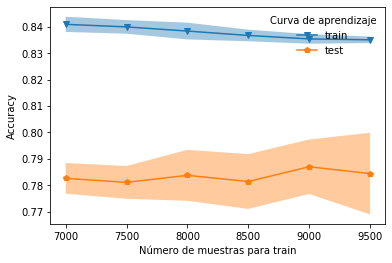

Eficiencia 0.7826000000000001  Int_Eficiencia 0.005821034654118137  Sensibilidad 0.7827206723028919  Int_Sensibilidad 0.012923451545173433  Precision 0.7827524303705296  Int_Precision 0.012114044277637268  F-Score 0.7825822511205505  Int_F-Score 0.006137995284496488  Error_Prueba 0.21739999999999998  Int_Error 0.005821034654118147  Tiempo ejecución 1038.358512878418


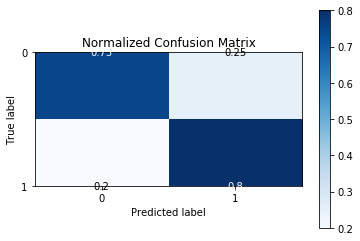

In [9]:
# Llamar función con el mejor modelo
Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = LRC(0.5, 'saga', impresion = True)
print('Eficiencia',Acc, ' Int_Eficiencia', IntAcc,' Sensibilidad', Sen, ' Int_Sensibilidad',IntSen,' Precision', Pre, ' Int_Precision',IntPre,' F-Score', f, ' Int_F-Score',IntF,' Error_Prueba', error,' Int_Error', stdError,' Tiempo ejecución', tiempo)